# Machine Learning Tutorial

#### Heavily inspired by Dr Michelle Lochner

In [117]:
import numpy as np
import matplotlib.pyplot as pl
import sncosmo
from astropy.table import Table
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import itertools

# Section 1: Setup

### How to read in a supernova light curve as an astropy table

I've saved the supernova light curves in a format that `sncosmo` can read: an astropy table. The cell below reads in a single object's data and displays the table. 

The columns are: <br>
`mjd`: Time in days since the first observation of the supernova <br>
`filter`: Which filter band the observation is in (i.e. which colour)<br>
`flux`: The flux (brightness) in that band<br>
`flux_error`: Uncertainty on the flux due to instrumental noise<br>
`zp`: What magnitude the flux is calibrated to (don't worry too much about this)<br>
`zpsys`: The system used to calibrate the flux (also don't worry)

In [38]:
lc_file = 'training_data/34.dat'
df_lc = pd.read_table(lc_file, sep=" ")
df_lc


,mjd,filter,flux,flux_error,zp,zpsys
0,0.000,desg,95.18,5.147,27.5,ab
1,0.008,desr,116.10,3.062,27.5,ab
2,0.024,desi,102.80,3.700,27.5,ab
3,0.047,desz,103.70,3.153,27.5,ab
4,2.997,desg,174.70,4.272,27.5,ab
...,...,...,...,...,...,...
109,97.028,desz,31.11,2.329,27.5,ab
110,104.969,desg,10.77,2.104,27.5,ab
111,104.993,desr,23.86,1.366,27.5,ab
112,105.012,desi,46.30,2.011,27.5,ab


# Section 2: Feature Extraction

### Use `sncosmo` to fit the SALT2 model to this light curve

In [34]:
def fit_supernova(df_lc):
    lc =  Table.from_pandas(df_lc)
    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)
    return res[0].parameters

In [35]:
prms = fit_supernova(df_lc)
print('Best fitting SALT2 parameters: [z, t0, x0, x1, c]:')
print(prms)

/home/kimeel/Documents/ml_tutorial/ml_tut_venv/lib/python3.6/site-packages/sncosmo/fitting.py:156: RuntimeWarning: Dropping following bands from data: desg(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


Best fitting SALT2 parameters: [z, t0, x0, x1, c]:
[ 7.28385580e-01  1.98758379e+01  2.50842809e-05  2.20457380e+00
 -2.65958520e-01]


### Check that the fitting worked correctly by using sncosmo's plot_lc function 

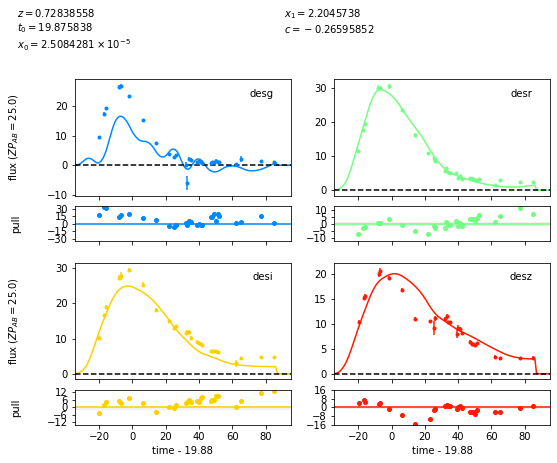

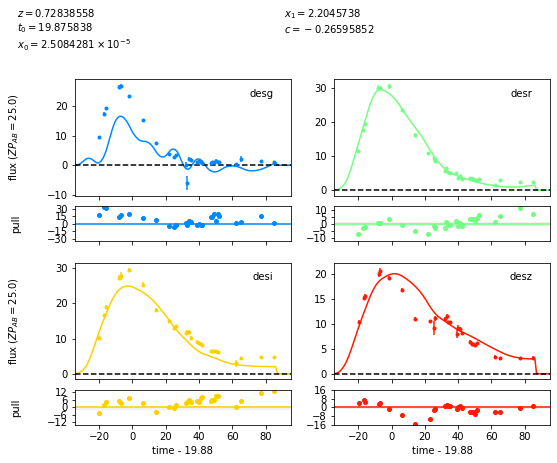

In [33]:
mod = sncosmo.Model('salt2-extended')
mod.parameters = prms
sncosmo.plot_lc(Table.from_pandas(df_lc), mod)

## Load pre-extracted feature set

In [59]:
df_features = pd.read_csv('salt2_features.txt', sep=" ", header = None, skiprows = [0], index_col=0)
df_features.columns = ['z', 't0', 'x0', 'x1', 'c']
df_features

,z,t0,x0,x1,c
0,,,,,
0,0.664885,64.334480,0.000003,2.734004,-0.218864
1,0.732481,-3.667963,0.000003,0.637645,-0.016488
2,1.054637,-60.927470,0.000018,0.014775,-0.397927
3,1.160663,-63.861990,0.000011,-3.000000,-0.036135
4,0.211863,58.629560,0.000012,3.000000,0.127932
...,...,...,...,...,...
1995,0.177504,-80.734400,0.000013,-1.557493,-0.008078
1996,0.564805,62.196930,0.000002,-2.685392,0.268322
1997,0.436681,18.547850,0.000007,3.000000,0.396048


## Load labels for feature set: 

#### 'Ia': 1 
#### 'II': 2 
#### 'Ibc': 3

In [125]:
df_labels = pd.read_csv('labels.txt', sep=" ", header = None, skiprows = [0],index_col=0)
df_labels.columns = ['Label']
df_labels['Label'].value_counts()

2    1261
1     485
3     254
Name: Label, dtype: int64

# Section 3: Machine Learning with Scikit-Learn

### Split data into train and test sets

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_features.values, df_labels['Label'].values, test_size=0.3, random_state=42)

In [83]:
# preprocess the data using standard scaler for zero mean and unit variance

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### K-Nearest Neighbours


In [84]:
clf = KNeighborsClassifier(n_neighbors=7)
# fitting the model
clf.fit(X_train, y_train)
# accuracy score
print('The accuracy score for KNN is', clf.score(X_test, y_test))

The accuracy score for KNN is 0.7266666666666667


In [92]:
knn = KNeighborsClassifier()

# specify parameters and distributions to sample from
param_grid = {"n_neighbors": np.arange(1,20)}

GSclf = GridSearchCV(knn, param_grid=param_grid,verbose = 3,n_jobs=7)
start = time.time()
GSclf.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(GSclf.cv_results_['params'])))

clf = GSclf.best_estimator_



Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  22 tasks      | elapsed:    0.2s


GridSearchCV took 0.36 seconds for 19 candidate parameter settings.


[Parallel(n_jobs=7)]: Done  95 out of  95 | elapsed:    0.4s finished


In [93]:
clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [94]:
print('The accuracy score for KNN is', clf.score(X_test, y_test))

The accuracy score for KNN is 0.7466666666666667


### Random forests

In [99]:
X_train, X_test, y_train, y_test = train_test_split(df_features.values, df_labels['Label'].values, test_size=0.3, random_state=42)

In [100]:
clf = RandomForestClassifier(n_estimators = 10)
# fitting the model
clf.fit(X_train, y_train)
# accuracy score
print('The accuracy score for RF is', clf.score(X_test, y_test))

The accuracy score for RF is 0.775


In [129]:
rf = RandomForestClassifier()

# specify parameters and distributions to sample from
param_grid = {"n_estimators": np.arange(10,20),
              "criterion": ['gini',"entropy"]}

GSclf = GridSearchCV(rf, param_grid=param_grid,verbose = 3,n_jobs=7)
start = time.time()
GSclf.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(GSclf.cv_results_['params'])))

rf_clf = GSclf.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  22 tasks      | elapsed:    0.3s


GridSearchCV took 1.12 seconds for 20 candidate parameter settings.


[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.1s finished


In [128]:
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
print('The accuracy score for RF is', rf_clf.score(X_test, y_test))

The accuracy score for RF is 0.7733333333333333


### SVM? ANN?

# Section 4: Evaluating the Classification

In [131]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=pl.cm.Blues,
                          save = False,
                          name = 'conf_matrix.pdf'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    pl.figure(figsize=(12,9))
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    if title != None:
        pl.title(title)
    #cbar = pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=60,fontweight = 'bold')
    pl.yticks(tick_marks, classes,fontweight = 'bold')

    ax = pl.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    #cbar.ax.tick_params(labelsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = format(cm[i, j], fmt)
        if text == '0.00':
            text = '0.0'
        pl.text(j, i, text,
                 horizontalalignment="center",
                 verticalalignment="center",
                 weight = 'medium',
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize = 15,
               )

    pl.grid(False)
    pl.ylabel('True label',fontsize = 18)
    pl.xlabel('Predicted label',fontsize = 18)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    # remove all the ticks and directly label each bar with respective value
    pl.tick_params(top=False, bottom=False, left=False, right=False)


    if save != False:
        pl.savefig(name,bbox_inches="tight")


Normalized confusion matrix


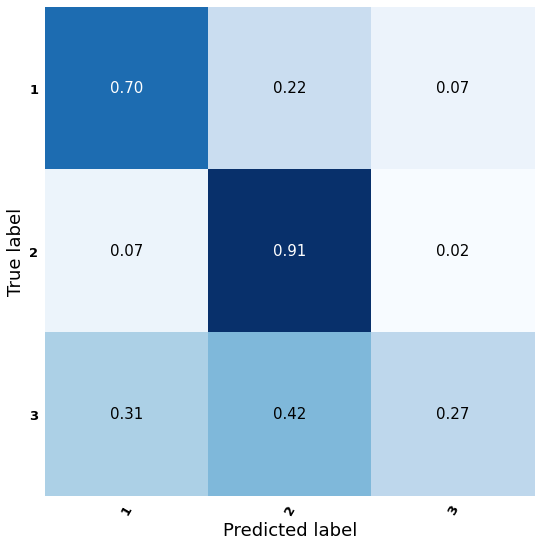

In [132]:
cnf_matrix = confusion_matrix(y_test,rf_clf.predict(X_test),labels=np.unique(df_labels['Label'].values))
plot_confusion_matrix(cnf_matrix, classes=np.unique(df_labels['Label'].values),normalize=True,
                      title='')